In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
from utils import target_loss 
from loader import build_dataloader
device = torch.device("cuda:0")

In [2]:
import pandas as pd
df = pd.read_csv("data.csv")
df.head()
df.shape

(10000, 105)

In [3]:
# Setup scinet model with 3 latent neurons
scinet = SciNet(51,1,3,64)

# Load and prepare training data
dataloader = build_dataloader(batch_size = 32)

In [4]:
# Training setup
SAVE_PATH = "trained_models/scinet1.dat"
N_EPOCHS = 100
optimizer = optim.Adam(scinet.parameters())
hist_error = []
hist_loss = []
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):
        time_series, fr, st, question, answer = minibatch['time_series'], minibatch['fr'], minibatch['st'], minibatch['question'], minibatch['answer']
        # print()
        # break
        # concat the time series with the features
        inputs = torch.cat((time_series, fr.reshape(-1,1), st.reshape(-1,1), question.reshape(-1, 1)), 1)
        # build the output
        outputs = answer

        optimizer.zero_grad()
        # print(inputs[0])
        pred = scinet.forward(inputs)
        # print(pred)
        # break
        loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    # break
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1 -- loss 3078.594727, RMS error 4.838736 
Epoch 2 -- loss 1123.759521, RMS error 3.065219 
Epoch 3 -- loss 581.037231, RMS error 2.142588 
Epoch 4 -- loss 361.072784, RMS error 1.565065 
Epoch 5 -- loss 249.246063, RMS error 1.219373 
Epoch 6 -- loss 187.055893, RMS error 1.047539 
Epoch 7 -- loss 148.512604, RMS error 0.902728 
Epoch 8 -- loss 132.686600, RMS error 0.869366 
Epoch 9 -- loss 117.709381, RMS error 0.803056 
Epoch 10 -- loss 103.888641, RMS error 0.772091 
Epoch 11 -- loss 92.899773, RMS error 0.694822 
Epoch 12 -- loss 88.279015, RMS error 0.697211 
Epoch 13 -- loss 79.713905, RMS error 0.647899 
Epoch 14 -- loss 69.190979, RMS error 0.570500 
Epoch 15 -- loss 66.401199, RMS error 0.569247 
Epoch 16 -- loss 68.768089, RMS error 0.604438 
Epoch 17 -- loss 71.392021, RMS error 0.598131 
Epoch 18 -- loss 62.253376, RMS error 0.528070 
Epoch 19 -- loss 59.695786, RMS error 0.519398 
Epoch 20 -- loss 58.416508, RMS error 0.480429 
Epoch 21 -- loss 49.792637, RMS error

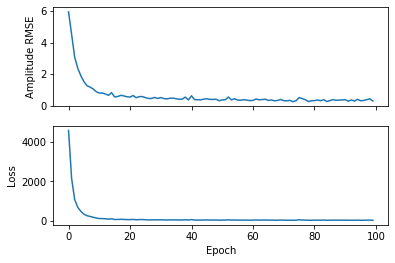

In [5]:
# Plot some training history data
%matplotlib inline 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(hist_error)
ax1.set_ylabel("Amplitude RMSE")
ax2.plot(hist_loss)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
plt.show()